In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('academic_performance_dataset_V2.csv')

df.head()

,ID No,Prog Code,Gender,YoG,CGPA,CGPA100,CGPA200,CGPA300,CGPA400,SGPA
0,42308,ICE,Female,2010,3.23,2.88,3.48,2.62,2.90,3.13
1,70978,BCH,Female,2010,3.58,3.25,4.26,3.37,3.47,3.02
2,31602,BCH,Male,2010,2.21,1.78,1.98,1.49,2.51,2.19
3,63847,BCH,Male,2010,2.70,2.67,2.44,2.00,2.35,3.19
4,30158,BCH,Female,2010,3.88,3.61,3.69,3.63,4.58,4.24


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3046 entries, 0 to 3045
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID No      3046 non-null   int64  
 1   Prog Code  3046 non-null   object 
 2   Gender     3046 non-null   object 
 3   YoG        3046 non-null   int64  
 4   CGPA       3046 non-null   float64
 5   CGPA100    3046 non-null   float64
 6   CGPA200    3046 non-null   float64
 7   CGPA300    3046 non-null   float64
 8   CGPA400    3046 non-null   float64
 9   SGPA       3046 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 238.1+ KB


<Axes: xlabel='Prog Code', ylabel='CGPA'>

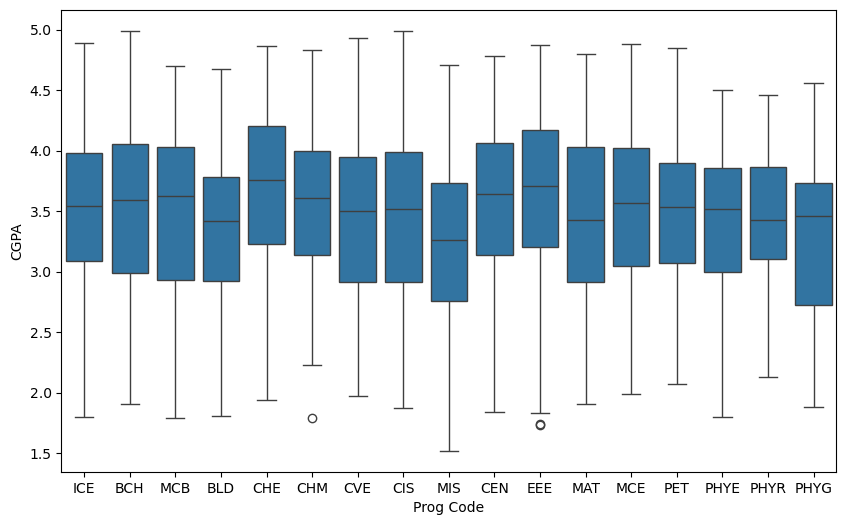

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Prog Code', y='CGPA')
# All the programs have median CGPA around 3.5

<Axes: xlabel='Gender', ylabel='CGPA'>

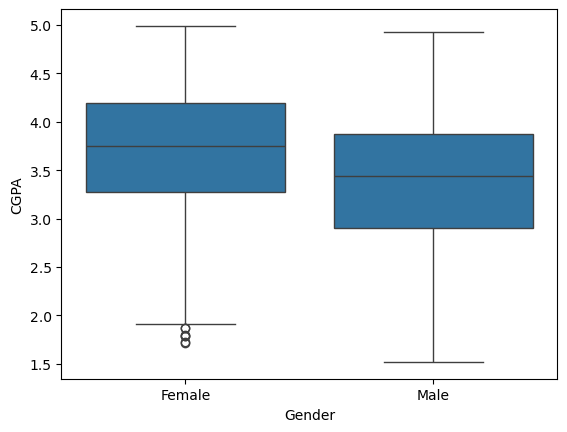

In [ ]:
sns.boxplot(data=df, x='Gender', y='CGPA')

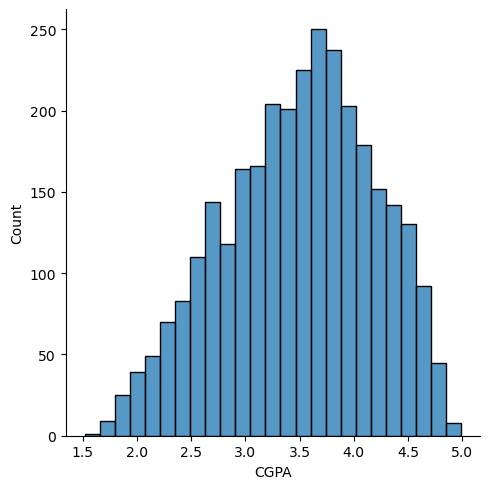

In [8]:
sns.displot(df['CGPA'])

((array([-3.50589902, -3.26243496, -3.1278141 , ...,  3.1278141 ,
          3.26243496,  3.50589902]),
  array([1.52, 1.69, 1.69, ..., 4.93, 4.99, 4.99])),
 (0.6874613872957523, 3.494812869336835, 0.9931270390286219))

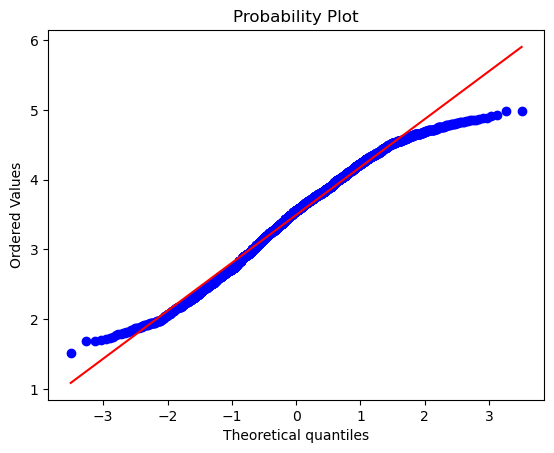

In [ ]:
from scipy import stats

stats.probplot(df['CGPA'], plot=plt)

In [ ]:
alpha = 0.05
statistic, p_val = stats.normaltest(df['CGPA'])
if p_val < alpha:
    print('The data is not normally distributed, with p-value:', p_val)
else:
    print('The data is normally distributed, with p-value:', p_val)

The data is not normally distributed, with p-value: 3.48684833720195e-28


In [ ]:
statistic, p_val = stats.skewtest(df['CGPA'])
if p_val < alpha:
    print('The data is not symmetric, with p-value:', p_val)
else:
    print('The data is symmetric, with p-value:', p_val)
print('Skewness:', df['CGPA'].skew()) # Negative skewness -> left skewed

The data is not symmetric, with p-value: 1.4637496000948255e-08
Skewness: -0.2549069209687609


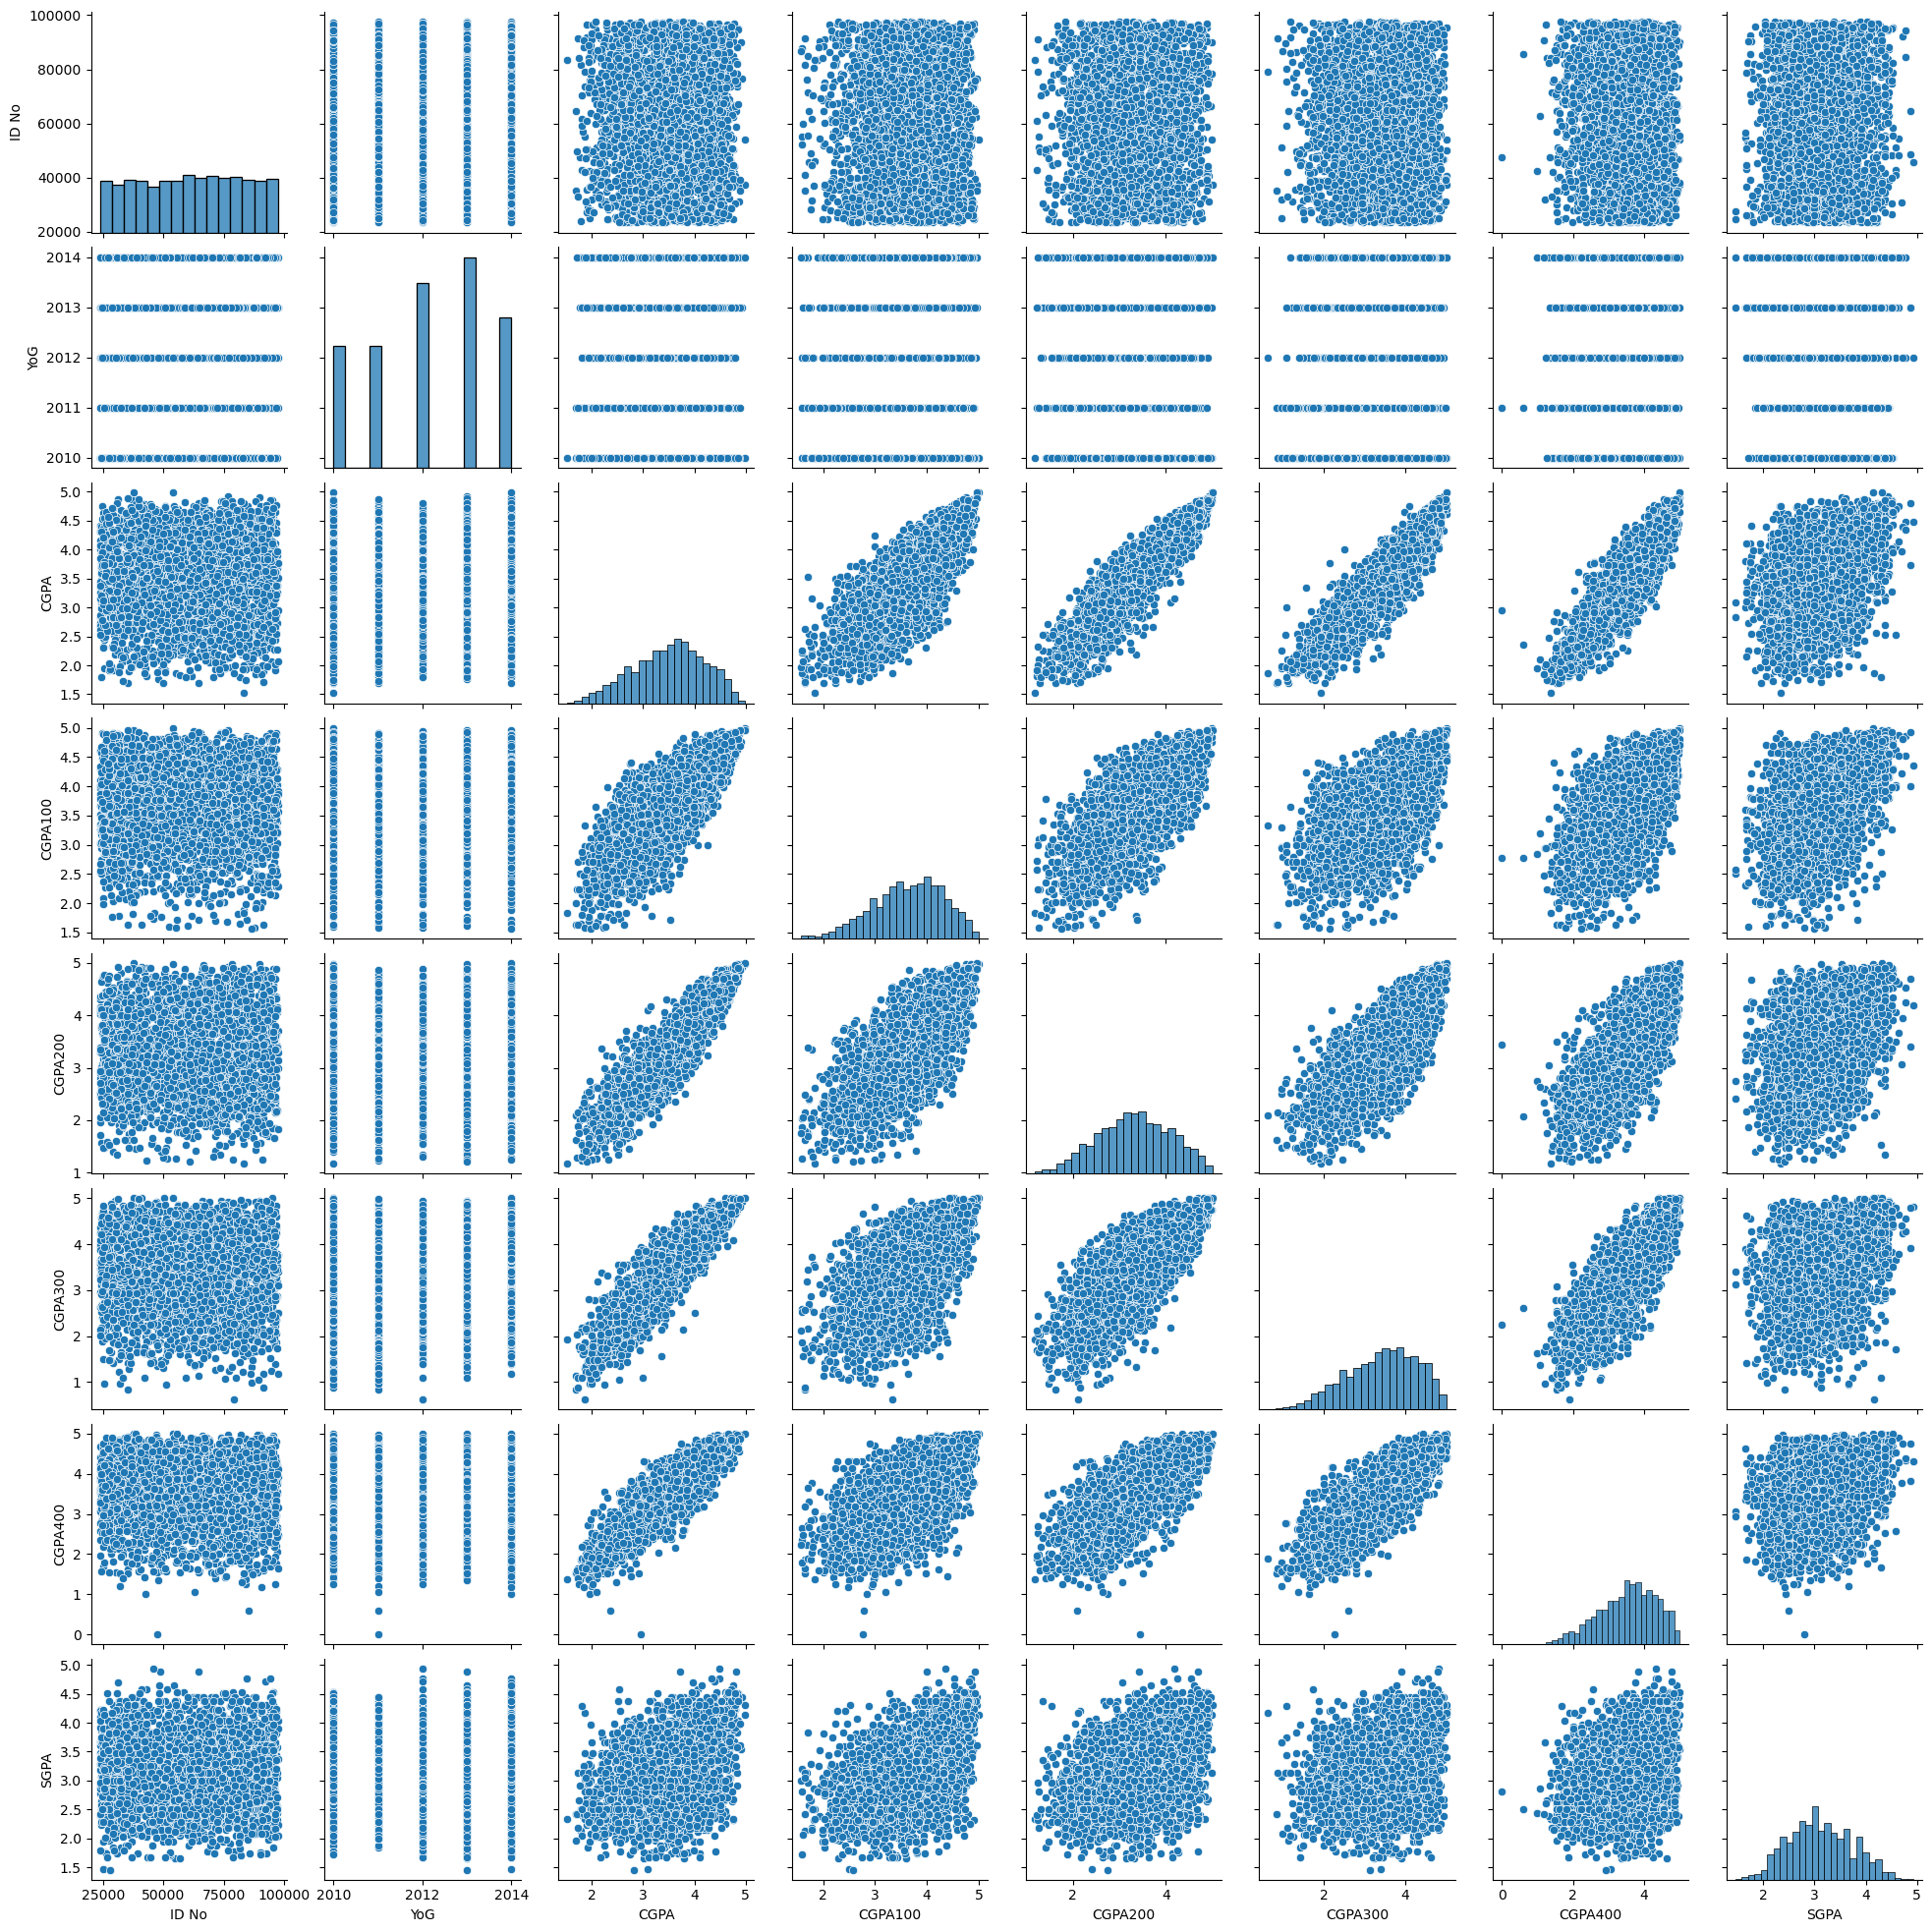

In [45]:
# Check linear relationship between CGPA and other variables
sns.pairplot(df.drop(['Gender', 'Prog Code'], axis=1))

<Axes: >

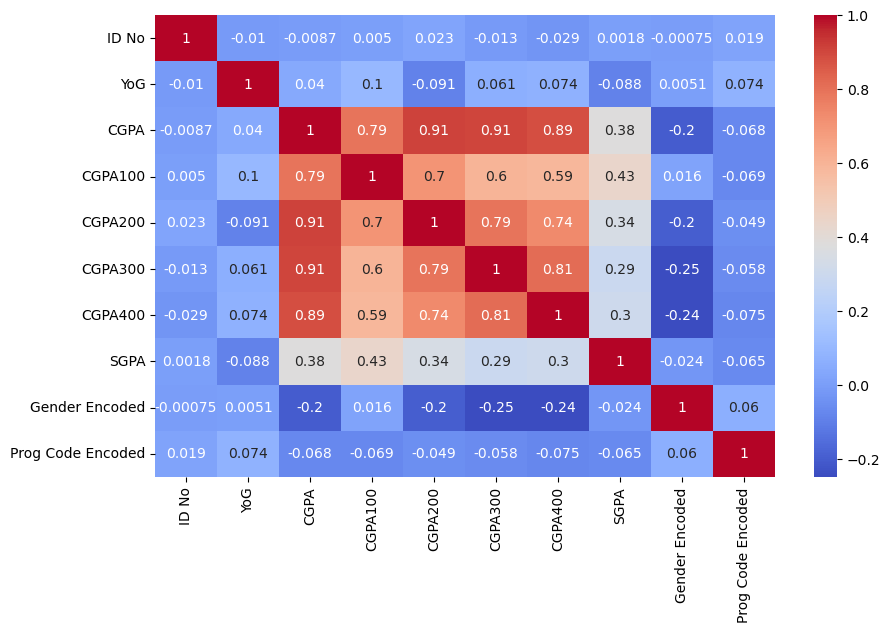

In [46]:
from sklearn.preprocessing import LabelEncoder
# Find correlation between CGPA and other variables
# Using heatmap
X = df.copy()
le = LabelEncoder()
X['Gender Encoded'] = le.fit_transform(X['Gender'])
X['Prog Code Encoded'] = le.fit_transform(X['Prog Code'])
X.drop(['Prog Code', 'Gender'], axis=1, inplace=True)
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
# CGPA of each year has strong relationship with CGPA of the previous year

In [41]:
# Custom Label Encoding in 2d array
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}
    
    
    def fit(self, X, y=None):
        for column in self.columns:
            le = LabelEncoder()
            le.fit(X[column])
            self.encoders[column] = le
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.columns:
            X[column] = self.encoders[column].transform(X[column])
        return X

In [56]:
# Preprocessing data
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

dataset = df.copy()
categorical_columns = ['Gender', 'Prog Code']

# Build pipeline
pipeline = Pipeline([
    ('encoder', CustomLabelEncoder(columns=categorical_columns)),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_regression, k=6)), # Select top 6 features (CGPA100, CGPA200, CGPA300, CGPA400, may be SGPA and Gender)
    ('model', RandomForestRegressor(random_state=42)) # Random Forest Regressor to predict CGPA, 
    # instead LinearRegression because the relationship between CGPA and other variables is not strong linear
])

param_grid = {
    "model__n_estimators": [50, 100, 200],  # Number of trees in the forest
    "model__max_depth": [None, 5, 10],  # Maximum depth of the trees
    "model__min_samples_split": [2, 5],  # Minimum number of samples required to split a node
    "model__min_samples_leaf": [1, 2]  # Minimum number of samples required at each leaf node
}

# Grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid=param_grid, 
    cv=5, # 5-fold cross validation
    scoring='neg_mean_squared_error',
    verbose=1
)

# Split data
dataset.drop(['CGPA'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(dataset, df['CGPA'], test_size=0.2, random_state=42)

# Train model
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print('Best model:', best_model)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean Squared Error: 0.009466170670459182
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best score: -0.0104216817606269
Best model: Pipeline(steps=[('encoder',
                 CustomLabelEncoder(columns=['Gender', 'Prog Code'])),
                ('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=6,
                             score_func=<function f_regression at 0x7937f2bd53a0>)),
                ('model',
                 RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=200, random_state=42))])


In [57]:
# Now I used above model to predict CGPA of a student based on his/her academic performance in previous years
# Random some data to test the model
random_data = X_test.sample(5)
predictions = best_model.predict(random_data)
print('Predictions:', predictions)
print('Actual:', y_test[random_data.index].values)

Predictions: [3.77609083 4.15508377 3.25676434 2.96325552 3.31644931]
Actual: [3.56 4.27 3.23 2.97 3.27]
